# Plot temperature response over time

## Method: 


## IRF:
Using forcings from RCMIP models and the impulse response function:
\begin{align*}
\text{IRF}(t)=& 0.885\cdot (\frac{0.587}{4.1}\cdot exp(\frac{-t}{4.1}) + \frac{0.413}{249} \cdot exp(\frac{-t}{249}))\\
\text{IRF}(t)= &  \sum_{i=1}^2\frac{\alpha \cdot c_i}{\tau_i}\cdot exp\big(\frac{-t}{\tau_1}\big) 
\end{align*}
with $\alpha = 0.885$, $c_1=0.587$, $\tau_1=4.1$, $c_2=0.413$ and $\tau_2 = 249$.

the estimated ERF$_x$ for some forcing agent $x$ as follows: 

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

# Code + figures

## Imports:

In [442]:
import xarray as xr
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [443]:
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, RESULTS_DIR

#PATH_DATASET = OUTPUT_DATA_DIR + '/forcing_data_rcmip_models.nc'
PATH_DT = OUTPUT_DATA_DIR + '/dT_data_rcmip_models.nc'

In [444]:
FIGURE_DIR = RESULTS_DIR + '/figures/'

In [445]:

climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'

### Define variables to look at:

In [446]:
from ar6_ch6_rcmipfigs.utils.misc_func import trans_scen2plotlabel, new_varname

# variables to plot:
variables_erf_comp = [
    'Effective Radiative Forcing|Anthropogenic|CH4',
    'Effective Radiative Forcing|Anthropogenic|Aerosols',
    'Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone',
    'Effective Radiative Forcing|Anthropogenic|F-Gases|HFC',
    'Effective Radiative Forcing|Anthropogenic|Other|BC on Snow']
# total ERFs for anthropogenic and total:
variables_erf_tot = ['Effective Radiative Forcing|Anthropogenic',
                     'Effective Radiative Forcing']
# Scenarios to plot:
scenarios_fl = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp370-lowNTCF-aerchemmip',  # 'ssp370-lowNTCF', Due to mistake here
                'ssp585', 'historical']
scenarios_nhist =['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp370-lowNTCF-aerchemmip',  # 'ssp370-lowNTCF', Due to mistake here
                'ssp585']# list(set(scenarios_fl)- {'historical'})
climatemodels_fl = ['Cicero-SCM', 'Cicero-SCM-ECS3', 'FaIR-1.5-DEFAULT', 'MAGICC7.1.0.beta-rcmip-phase-1', 'OSCARv3.0']

# List of delta T for variables
name_deltaT = 'Delta T'
variables_dt_comp = [new_varname(var, name_deltaT) for var in variables_erf_comp]

In [447]:
# Years to plot:
years = ['2040', '2100']

#scn_trans = [trans_scen2plotlabel(label) for label in scenarios_nhist]
scn_trans = scenarios_nhist # scenarios except historical

variables_tot = ['Total']
variables_sum = ['Sum SLCFs']
iterables = [years, [var.split('|')[-1] for var in variables_erf_comp]]
iterables2 = [years, variables_tot]
iterables3 = [years, variables_sum]



def setup_table(scenario_n='',
                its=None):
    if its is None:
        its = [years, [var.split('|')[-1] for var in variables_erf_comp]]

    _i = pd.MultiIndex.from_product(its, names=['', ''])
    table = pd.DataFrame(columns=scn_trans, index = _i)#.transpose()
    table.index.name=scenario_n
    return table


def setup_table_prop(scenario_n='', years=None, vars=None):
    if vars is None:
        vars = [var.split('|')[-1] for var in variables_erf_comp]
    if years is None:
        years = ['2040', '2100']
    its = [years, vars]
    _i = pd.MultiIndex.from_product(its, names=['', ''])
    table = pd.DataFrame(columns=scn_trans, index = _i)#.transpose()
    table.index.name=scenario_n
    return table


def setup_table3(scenario_n=''):
    return setup_table(scenario_n=scenario_n, its=iterables3)





ssp119 ssp126 ssp245 ssp370 ssp370-lowNTCF-aerchemmip  \
                                                                                
2040 CH4                   NaN    NaN    NaN    NaN                       NaN   
     Aerosols              NaN    NaN    NaN    NaN                       NaN   
     Tropospheric Ozone    NaN    NaN    NaN    NaN                       NaN   
     HFC                   NaN    NaN    NaN    NaN                       NaN   
     BC on Snow            NaN    NaN    NaN    NaN                       NaN   
2100 CH4                   NaN    NaN    NaN    NaN                       NaN   
     Aerosols              NaN    NaN    NaN    NaN                       NaN   
     Tropospheric Ozone    NaN    NaN    NaN    NaN                       NaN   
     HFC                   NaN    NaN    NaN    NaN                       NaN   
     BC on Snow            NaN    NaN    NaN    NaN                       NaN   

                        ssp585  
                                
2040 CH4                   NaN  
     Aerosols              NaN  
     Tropospheric Ozone    NaN  
     HFC                   NaN  
     BC on Snow            NaN  
2100 CH4                   NaN  
     Aerosols              NaN  
     Tropospheric Ozone    NaN  
     HFC                   NaN  
     BC on Snow            NaN

## Open dataset:

### Integrate:
The code below opens the file generated in [2_compute_delta_T.ipynb](2_compute_delta_T.ipynb) by integrating

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

where IRF is the impulse response function and ERF is the effective radiative forcing from RCMIP. 

In [448]:
ds_DT = xr.open_dataset(PATH_DT)

## Compute sum of all SLCF forcers

In [449]:
from ar6_ch6_rcmipfigs.utils.misc_func import get_cmap_dic, get_scenario_ls_dic, get_scenario_c_dic

In [450]:

# ds_DT = dic_ds[0.885]
s_y = '1850'
# cdic = get_scenario_c_dic()

cdic = get_scenario_c_dic()# get_cmap_dic(ds_DT[scenario].values)
lsdic = get_scenario_ls_dic()# _scget_ls_dic(ds_DT[climatemodel].values)


def sum_name(var): return '|'.join(var.split('|')[0:2]) + '|' + 'All'


var = variables_erf_comp[0]
f_totn = sum_name(var)
dt_totn = sum_name(new_varname(var, name_deltaT))

# make xarray with variable as new dimension:
_lst_f = []
_lst_dt = []
for var in variables_erf_comp:
    _lst_f.append(ds_DT[var])
    _lst_dt.append(ds_DT[new_varname(var, name_deltaT)])
erf_all = sum_name('Effective Radiative Forcing|Anthropogenic|all')
dt_all = sum_name(new_varname('Effective Radiative Forcing|Anthropogenic|all', name_deltaT))
ds_DT[erf_all] = xr.concat(_lst_f, pd.Index(variables_erf_comp, name='variable'))
ds_DT[dt_all] = xr.concat(_lst_dt, pd.Index(variables_erf_comp, name='variable'))

In [540]:
ref_year='2021'
scntab_dic = {}
#tab_tot = setup_table2()
#tab_tot_sd = setup_table2()
def table_of_sts(ds_DT, scenarios_nhist, variables, tab_vars, years, ref_year, sts = 'mean'):
    tab_tot = setup_table_prop(years=years, vars = tab_vars)
    for scn in scenarios_nhist:
        for var, tabvar in zip(variables, tab_vars):
            #tabvar = 'Total'# var.split('|')[-1]
            dtvar = new_varname(var, name_deltaT)
            tabscn = scn#trans_scen2plotlabel(scn)
            for year in years:
                _tab_da =ds_DT[dtvar].sel(scenario=scn, time=slice(year,year))-  ds_DT[dtvar].sel(scenario=scn, time=slice(ref_year,ref_year)).squeeze()
                if sts=='mean':
                    tab_tot.loc[(year, tabvar),tabscn]=_tab_da.mean('climatemodel').values[0]
                if sts=='median':
                    tab_tot.loc[(year, tabvar),tabscn]=_tab_da.median('climatemodel').values[0]
                elif sts=='std':
                    tab_tot.loc[(year, tabvar),tabscn]=_tab_da.std('climatemodel').values[0]

                #tab_tot_sd.loc[(year, tabvar),tabscn]=_tab_da.std('climatemodel').values[0]
    return tab_tot
tab_tot = table_of_sts(ds_DT, scenarios_nhist, ['Delta T|Anthropogenic'], ['Total'], years, ref_year)
tab_tot_sd = table_of_sts(ds_DT, scenarios_nhist, ['Delta T|Anthropogenic'], ['Total'], years, ref_year, sts='std')

tab = table_of_sts(ds_DT, scenarios_nhist, variables_dt_comp, [var.split('|')[-1] for var in variables_dt_comp], years, ref_year)
tab_sd = table_of_sts(ds_DT, scenarios_nhist, variables_dt_comp, [var.split('|')[-1] for var in variables_dt_comp], years, ref_year, sts='std')
# Compute sum of SLCFs
_ds = ds_DT.copy()
vall = 'Delta T|Anthropogenic|All'
_ds[vall] =_ds[vall].sum('variable')
tab_slcf_sum = table_of_sts(_ds, scenarios_nhist, [vall], ['Sum SLCFs'], years, ref_year)
tab_slcf_sum_sd = table_of_sts(_ds, scenarios_nhist, [vall], ['Sum SLCFs'], years, ref_year, sts='std')

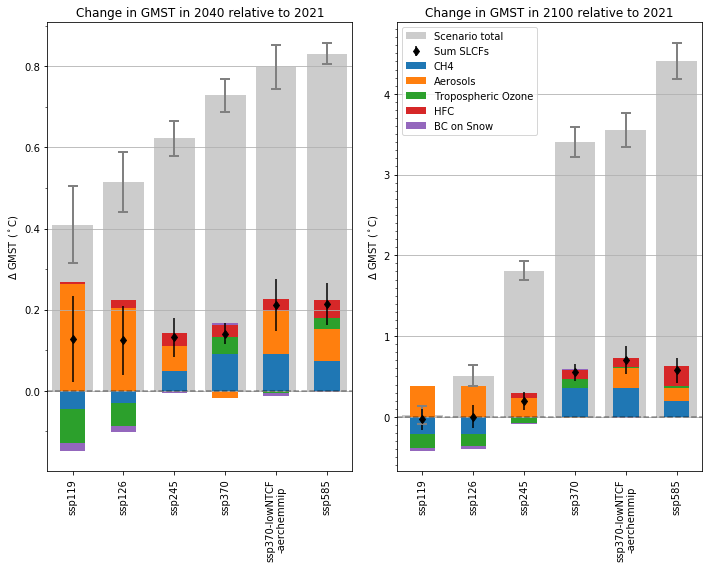

In [453]:
from ar6_ch6_rcmipfigs.constants import RESULTS_DIR
from matplotlib.ticker import (MultipleLocator)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,len(years), figsize=[10,8], sharey=False)
tits = ['Near Term surface temperature change (2040 relative to 2021)',
       'Long Term surface T change 2100 relatie to 2021)']
tits = ['Change in GMST in 2040 relative to 2021', 'Change in GMST in 2100 relative to 2021']
for yr, ax, tit in zip(years, axs, tits):
    ntot = 'Scenario total'
    tot_yr = tab_tot.loc[yr].rename({'Total':ntot, 'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    tot_sd_yr = tab_tot_sd.loc[yr].rename({'Total':ntot, 'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    #l =ax.bar(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2, yerr=tab_tot_sd)
    sum_yr = tab_slcf_sum.loc[yr].rename({'Total':ntot, 'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    sum_sd_yr = tab_slcf_sum_sd.loc[yr].rename({'Total':ntot, 'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    ax.bar(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2, yerr=tot_sd_yr.transpose()[ntot].values, 
           error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))
    ntot = 'Sum SLCFs'
    #ax.bar(sum_yr.transpose().index, sum_yr.transpose()[ntot].values, color='r', label=ntot, alpha=.2, yerr=sum_sd_yr.transpose()[ntot].values,
    #      error_kw=dict(ecolor='r', lw=2, capsize=0, capthick=1))
    
    
    s_x = sum_yr.transpose().index
    s_y =  sum_yr.transpose()[ntot].values
    s_err= sum_sd_yr.transpose()[ntot].values
    ax.errorbar(s_x,s_y, color='k',fmt='d', label=ntot, yerr=s_err, linestyle="None")#,
          #error_kw=dict(ecolor='r', lw=2, capsize=0, capthick=1))

    _tab = tab.loc[yr].transpose().rename({'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    
    a = _tab.plot(kind='bar', stacked=True, ax=ax, legend=(yr!='2040'))#, grid=True)#stac)
    if not yr=='2040':
        ax.legend()#[l],labels=['Sce!!nario total'], loc = 4)#'lower right')
    
    ax.axhline(0, linestyle='--', color='k', alpha=0.4)
    ax.set_title(tit)
    ax.set_ylabel('$\Delta$ GMST ($^\circ$C)')
    ax.yaxis.set_minor_locator(MultipleLocator(.1))
    ax.grid(axis='y', which='major')
    
fn = RESULTS_DIR+'/figures/stack_bar_influence_years.png'
plt.tight_layout()
ax = plt.gca()

ax.tick_params(axis='y',which='minor')#,bottom='off')
plt.savefig(fn, dpi=300)

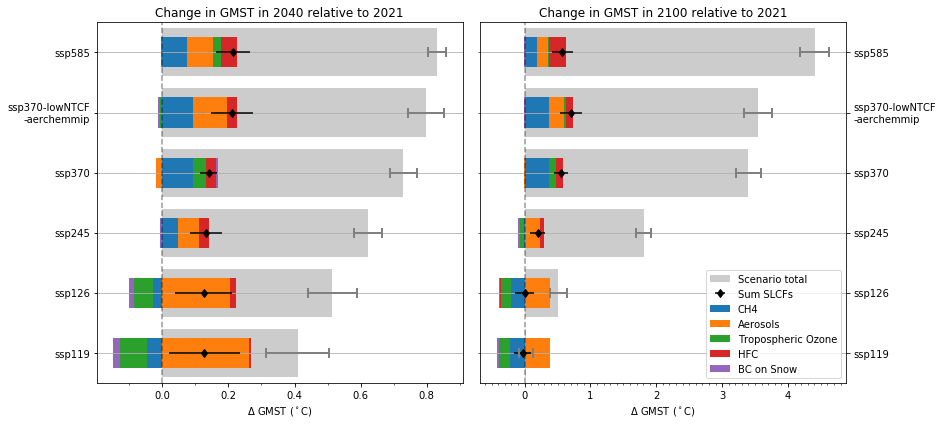

In [590]:
from matplotlib import transforms
from ar6_ch6_rcmipfigs.constants import RESULTS_DIR
from matplotlib.ticker import (MultipleLocator)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,len(years), figsize=[12,6], sharex=False, sharey=True)
tits = ['Near Term surface temperature change (2040 relative to 2021)',
       'Long Term surface T change 2100 relatie to 2021)']
tits = ['Change in GMST in 2040 relative to 2021', 'Change in GMST in 2100 relative to 2021']
for yr, ax, tit in zip(years, axs, tits):
    ntot = 'Scenario total'
    tot_yr = tab_tot.loc[yr].rename({'Total':ntot, 'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    tot_sd_yr = tab_tot_sd.loc[yr].rename({'Total':ntot, 'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    #l =ax.bar(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2, yerr=tab_tot_sd)
    sum_yr = tab_slcf_sum.loc[yr].rename({'Total':ntot, 'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    sum_sd_yr = tab_slcf_sum_sd.loc[yr].rename({'Total':ntot, 'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    ax.barh(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2, xerr=tot_sd_yr.transpose()[ntot].values, 
           error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))
    ntot = 'Sum SLCFs'
    #ax.bar(sum_yr.transpose().index, sum_yr.transpose()[ntot].values, color='r', label=ntot, alpha=.2, yerr=sum_sd_yr.transpose()[ntot].values,
    #      error_kw=dict(ecolor='r', lw=2, capsize=0, capthick=1))
    
    
    s_x = sum_yr.transpose().index
    s_y =  sum_yr.transpose()[ntot].values
    s_err= sum_sd_yr.transpose()[ntot].values
    ax.errorbar(s_y,s_x, xerr=s_err,label=ntot, color='k',fmt='d',  linestyle="None")#,
          #error_kw=dict(ecolor='r', lw=2, capsize=0, capthick=1))

    _tab = tab.loc[yr].transpose().rename({'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    
    a = _tab.plot(kind='barh', stacked=True, ax=ax, legend=(yr!='2040'))#, grid=True)#stac)
    if not yr=='2040':
        ax.legend()#[l],labels=['Sce!!nario total'], loc = 4)#'lower right')
    
    ax.axvline(0, linestyle='--', color='k', alpha=0.4)
    ax.set_title(tit)
    ax.set_xlabel('$\Delta$ GMST ($^\circ$C)')
    ax.xaxis.set_minor_locator(MultipleLocator(.1))
    ax.grid(axis='y', which='major')
    
fn = RESULTS_DIR+'/figures/stack_bar_influence_years.png'
plt.tight_layout()
ax = plt.gca()

ax.tick_params(axis='y',which='minor')#,bottom='off') 
ax.tick_params( labelright=True, right=True, left=False)
plt.savefig(fn, dpi=300)

## Test combined error bars: 

In [591]:
def sigma_DT(dT, sig_alpha, mu_alpha, dim='climatemodel'):
    sig_DT = dT.std(dim)
    mu_DT = dT.mean(dim)
    return ((sig_DT + mu_DT)*(sig_alpha+mu_alpha)- mu_DT*mu_alpha)/mu_alpha
def sigma_com(sig_DT, mu_DT, sig_alpha, mu_alpha, dim='climatemodel'):
    return (((sig_DT**2 + mu_DT**2)*(sig_alpha**2+mu_alpha**2)- mu_DT**2*mu_alpha**2)/mu_alpha**2)**(.5)
sum_DT_std = table_of_sts(_ds, scenarios_nhist, [vall], ['Sum SLCFs'], years, ref_year, sts='std')
sum_DT_mean = table_of_sts(_ds, scenarios_nhist, [vall], ['Sum SLCFs'], years, ref_year, sts='mean')
tot_DT_std = table_of_sts(ds_DT, scenarios_nhist, ['Delta T|Anthropogenic'],['Total'], years, ref_year, sts='std')
tot_DT_mean = table_of_sts(ds_DT, scenarios_nhist, ['Delta T|Anthropogenic'], ['Total'],years, ref_year, sts='mean')

yerr_sum = sigma_com(sum_DT_std, sum_DT_mean, .24, .885 )
yerr_tot = sigma_com(tot_DT_std, tot_DT_mean, .24, .885)#.rename('')

#tab_sig_DT = setup_table_prop()

In [574]:
tot_DT_std

,,ssp119,ssp126,ssp245,ssp370,ssp370-lowNTCF-aerchemmip,ssp585
,,,,,,,
2040,Total,0.0949343,0.0733085,0.042811,0.0406404,0.054927,0.0266538
2100,Total,0.107939,0.128872,0.118113,0.186669,0.211884,0.223506


In [575]:
tot_DT_mean

,,ssp119,ssp126,ssp245,ssp370,ssp370-lowNTCF-aerchemmip,ssp585
,,,,,,,
2040,Total,0.409698,0.514518,0.621916,0.728237,0.798053,0.831031
2100,Total,0.0245512,0.510912,1.80734,3.39964,3.54998,4.40707


In [576]:
yerr_tot

,,ssp119,ssp126,ssp245,ssp370,ssp370-lowNTCF-aerchemmip,ssp585
,,,,,,,
2040,Total,0.174763,0.166298,0.147966,0.162271,0.189862,0.162333
2100,Total,0.128898,0.23008,0.422704,0.753995,0.806981,0.956026


In [588]:
yerr_tot

,,ssp119,ssp126,ssp245,ssp370,ssp370-lowNTCF-aerchemmip,ssp585
,,,,,,,
2040,Total,0.14839,0.158865,0.174391,0.201927,0.223779,0.22705
2100,Total,0.112035,0.192422,0.505173,0.942005,0.987421,1.21737


In [580]:
yerr_sum

,,ssp119,ssp126,ssp245,ssp370,ssp370-lowNTCF-aerchemmip,ssp585
,,,,,,,
2040,Sum SLCFs,0.143929,0.118508,0.0769033,0.0521848,0.107464,0.0946467
2100,Sum SLCFs,0.145571,0.162633,0.162612,0.211427,0.306423,0.273927


In [ ]:
tot_DT 

In [578]:
sig_DT = 0.094
mu_DT = 0.40
sig_alph=0.14
mu_alph = 0.885
((sig_DT + mu_DT)*(sig_alph +mu_alph)- mu_DT*mu_alph)/mu_alph

0.17214689265536715

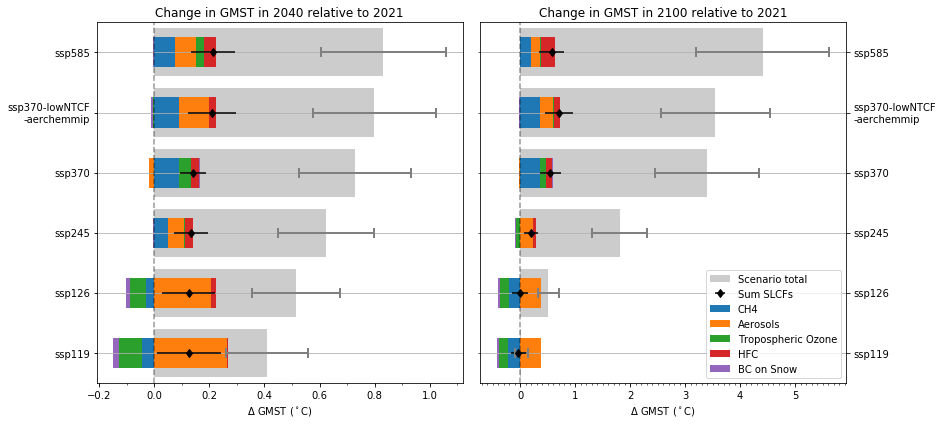

In [592]:
from matplotlib import transforms
from ar6_ch6_rcmipfigs.constants import RESULTS_DIR
from matplotlib.ticker import (MultipleLocator)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,len(years), figsize=[12,6], sharex=False, sharey=True)
tits = ['Near Term surface temperature change (2040 relative to 2021)',
       'Long Term surface T change 2100 relatie to 2021)']
tits = ['Change in GMST in 2040 relative to 2021', 'Change in GMST in 2100 relative to 2021']
for yr, ax, tit in zip(years, axs, tits):
    ntot = 'Scenario total'
    tot_yr = tab_tot.loc[yr].rename({'Total':ntot, 'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    tot_sd_yr = yerr_tot.loc[yr].rename({'Total':ntot, 'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    #l =ax.bar(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2, yerr=tab_tot_sd)
    sum_yr = tab_slcf_sum.loc[yr].rename({'Total':ntot, 'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    sum_sd_yr = yerr_sum.loc[yr].rename({'Total':ntot, 'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    ax.barh(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2, xerr=tot_sd_yr.transpose()[ntot].values, 
           error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))
    ntot = 'Sum SLCFs'
    #ax.bar(sum_yr.transpose().index, sum_yr.transpose()[ntot].values, color='r', label=ntot, alpha=.2, yerr=sum_sd_yr.transpose()[ntot].values,
    #      error_kw=dict(ecolor='r', lw=2, capsize=0, capthick=1))
    
    
    s_x = sum_yr.transpose().index
    s_y =  sum_yr.transpose()[ntot].values
    s_err= sum_sd_yr.transpose()[ntot].values
    ax.errorbar(s_y,s_x, xerr=s_err,label=ntot, color='k',fmt='d',  linestyle="None")#,
          #error_kw=dict(ecolor='r', lw=2, capsize=0, capthick=1))

    _tab = tab.loc[yr].transpose().rename({'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    
    a = _tab.plot(kind='barh', stacked=True, ax=ax, legend=(yr!='2040'))#, grid=True)#stac)
    if not yr=='2040':
        ax.legend()#[l],labels=['Sce!!nario total'], loc = 4)#'lower right')
    
    ax.axvline(0, linestyle='--', color='k', alpha=0.4)
    ax.set_title(tit)
    ax.set_xlabel('$\Delta$ GMST ($^\circ$C)')
    ax.xaxis.set_minor_locator(MultipleLocator(.1))
    ax.grid(axis='y', which='major')
    
fn = RESULTS_DIR+'/figures/stack_bar_influence_years.png'
plt.tight_layout()
ax = plt.gca()

ax.tick_params(axis='y',which='minor')#,bottom='off') 
ax.tick_params( labelright=True, right=True, left=False)
plt.savefig(fn, dpi=300)

In [541]:
txts = 11
xpos = -0.8
axs[0].text(xpos, 5.1, 'Strong climate \nmitigation \nStrong air pollution \ncontrol',
         {'color': 'black', 'fontsize': txts, 'ha': 'center', 'va': 'center',
          'bbox': dict(boxstyle="rarrow", fc="white", ec="blue", pad=0.5)})
#axs[0].text(xpos, 4.6, 'Strong air pollution \ncontrol',
#         {'color': 'black', 'fontsize': txts, 'ha': 'center', 'va': 'center',
#          'bbox': dict(boxstyle="rarrow", fc="white", ec="orange", pad=0.2)})
axs[0].annotate("",
            xy=(-.2, 0.2), xycoords='data',
            xytext=(-.01, 0.8), textcoords='data',
            arrowprops=dict(arrowstyle="-",
                            connectionstyle= "bar,fraction=0.3"),
            )
strings = [ 'Strong climate \nmitigation \n','Strong air pollution \ncontrol']
colors = ['blue', 'orange']
t = axs[0].transData
for s, c in zip(strings, colors):
        text = axs[0].text(xpos, 4, s + " ", color=c, transform=t)#, **kwargs)
        canvas = axs[0].figure.canvas
        orientation='horizontalas'
        # Need to draw to update the text position.
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        if orientation == 'horizontal':
            t = transforms.offset_copy(
                text.get_transform(), x=ex.width, units='dots')
        else:
            t = transforms.offset_copy(
                text.get_transform(), y=ex.height, units='dots')
axs[0].annotate("Test", xy=(-0.5, 0.5), xycoords="axes fraction")
plt.savefig(fn, dpi=300)


<Figure size 432x288 with 0 Axes>

In [503]:
def demo_con_style(ax, connectionstyle):
    x1, y1 = 0.3, 0.2
    x2, y2 = 0.8, 0.6

    ax.plot([x1, x2], [y1, y2], ".")
    ax.annotate("",
                xy=(x1, y1), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="->", color="0.5",
                                shrinkA=5, shrinkB=5,
                                patchA=None, patchB=None,
                                connectionstyle=connectionstyle,
                                ),
                )

    ax.text(.05, .95, connectionstyle.replace(",", ",\n"),
            transform=ax.transAxes, ha="left", va="top")


In [454]:
ax.get_xticks()

array([0, 1, 2, 3, 4, 5])

- De vi allerede har.

Hvis vi skulle lagt til usikkerhet?
- Ville lagt til usikkerhet gjennom ECS -- 
    - Regne ut de samme tallene for 3 verdier av ECS. 
    - Monte carlo trekk med en fordeling på ECS. 
    - 

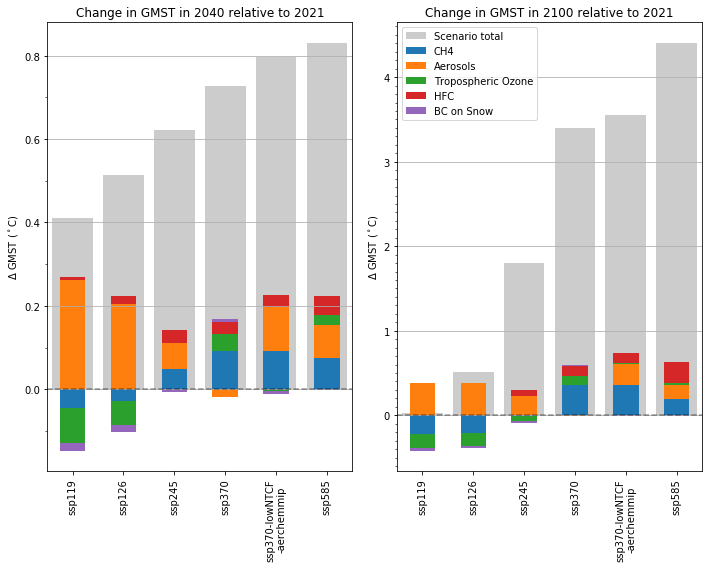

In [455]:
from ar6_ch6_rcmipfigs.constants import RESULTS_DIR
from matplotlib.ticker import (MultipleLocator)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,len(years), figsize=[10,8], sharey=False)
tits = ['Near Term surface temperature change (2040 relative to 2021)',
       'Long Term surface T change 2100 relatie to 2021)']
tits = ['Change in GMST in 2040 relative to 2021', 'Change in GMST in 2100 relative to 2021']
for yr, ax, tit in zip(years, axs, tits):
    ntot = 'Scenario total'
    tot_yr = tab_tot.loc[yr].rename({'Total':ntot, 'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    l =ax.bar(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2)
    _tab = tab.loc[yr].transpose().rename({'ssp370-lowNTCF-aerchemmip':'ssp370-lowNTCF\n-aerchemmip'})
    
    a = _tab.plot(kind='bar', stacked=True, ax=ax, legend=(yr!='2040'))#, grid=True)#stac)
    if not yr=='2040':
        ax.legend()#[l],labels=['Sce!!nario total'], loc = 4)#'lower right')
    
    ax.axhline(0, linestyle='--', color='k', alpha=0.4)
    ax.set_title(tit)
    ax.set_ylabel('$\Delta$ GMST ($^\circ$C)')
    ax.yaxis.set_minor_locator(MultipleLocator(.1))
    ax.grid(axis='y', which='major')
    
fn = RESULTS_DIR+'/figures/stack_bar_influence_years.png'
plt.tight_layout()
ax = plt.gca()

ax.tick_params(axis='y',which='minor')#,bottom='off')
plt.savefig(fn, dpi=300)